In [84]:
import casadi as ca
import numpy as np
import cvxpy as cp
import control as ct
from matplotlib import pyplot as plt
import math

### Dynamics
From https://arxiv.org/pdf/1611.09240

$$\begin{align}
\dot{\textbf{p}} &= \textbf{v}\\
\dot{\textbf{v}} &= \frac{1}{m}(\textbf{R}_{IB}\sum_{i=0}^{N_{r}}\textbf{F}_{T,i})+
\begin{bmatrix}
0 \\
0 \\
-g \\
\end{bmatrix}\\
\dot{\textbf{R}}_{IB} &= \textbf{R}_{IB}\lfloor\boldsymbol{\omega}\times\rfloor\\
\textbf{J}\dot{\boldsymbol{\omega}}&=-\boldsymbol{\omega}\times\textbf{J}\boldsymbol{\omega} + \textit{A}
\begin{bmatrix}
n_{1}^{2} \\
\vdots \\
n_{N_{r}}^{2} \\
\end{bmatrix}
\end{align}
$$

More detailed state space model, equivalent to the above from this paper: https://arxiv.org/pdf/2504.13286

$$
\begin{align}
m\ddot{X} &= F(\cos{\phi}\sin{\theta}\cos{\psi}+\sin{\phi}\sin{\psi}) \\
m\ddot{Y} &= F(\cos{\phi}\sin{\theta}\sin{\psi}+\sin{\phi}\cos{\psi}) \\
m\ddot{Z} &= F(\cos{\phi}\cos{\theta})-mg \\
I_{x}\ddot{\phi} &= T_{x}l+\dot{\theta}\dot{\psi}(I_{y}-I_{z}) \\
I_{y}\ddot{\theta} &= T_{y}l+\dot{\psi}\dot{\phi}(I_{z}-I_{x}) \\
I_{z}\ddot{\psi} &= T_{z}l+\dot{\phi}\dot{\theta}(I_{x}-I_{y}) \\
F & = F_1 + F_2 + F_3 + F_4
\end{align}
$$

#### `TODO` Add noise to the state dynamics

In [76]:
## Dynamics
x = ca.SX.sym("x", 12)
u = ca.SX.sym("u", 4)

m = 1  # kg
g = 9.81  # m/s^2
Ix, Iy, Iz = 0.11, 0.11, 0.04  # kg m^2
l = 0.2  # m (this drops out when controlling via torques)
dt=0.01 ## Simulate step at 100Hz

parms = {"Q": np.eye(12), "R": np.eye(4), "N": 10, "Qf": np.eye(12), "dynamic": True}

# non linear dynamics
x_x, x_y, x_z, x_phi, x_theta, x_psi, x_dx, x_dy, x_dz, x_dphi, x_dtheta, x_dpsi = ca.vertsplit(x, 1)
u_F, u_Tx, u_Ty, u_Tz = ca.vertsplit(u, 1)

dx_x = x_dx
dx_y = x_dy
dx_z = x_dz
dx_phi = x_dphi
dx_theta = x_dtheta
dx_psi = x_dpsi
dx_dx = u_F/m * (ca.cos(x_phi)*ca.sin(x_theta)*ca.cos(x_psi) + ca.sin(x_phi)*ca.sin(x_psi))
dx_dy = u_F/m * (ca.cos(x_phi)*ca.sin(x_theta)*ca.sin(x_psi)+ca.sin(x_phi)*ca.cos(x_psi))
dx_dz = u_F/m * ca.cos(x_phi) * ca.cos(x_theta) - g
dx_dphi = 1/Ix * (u_Tx + x_dtheta * x_dpsi*(Iy - Iz))
dx_dtheta = 1/Iy * (u_Ty + x_dpsi*x_dphi*(Iz - Ix))
dx_dpsi = 1/Iz * (u_Tz + x_dphi*x_dtheta*(Ix-Iy))

x_dot = ca.vertcat(dx_x, dx_y, dx_z, dx_phi, dx_theta, dx_psi, dx_dx, dx_dy, dx_dz, dx_dphi, dx_dtheta, dx_dpsi)
f = x_dot
dynamics = ca.Function("quadrotor_dyn", [x, u], [x + dt * x_dot])

# this is continuous or discrete time?
#jac_dyn_x = ca.jacobian(self.x + self.dt * x_dot, self.x)
#jac_dyn_u = ca.jacobian(self.x + self.dt * x_dot, self.u)
#self.jac_dyn_x = ca.Function("jac_dyn_x", [self.x, self.u], [jac_dyn_x])
#self.jac_dyn_u = ca.Function("jac_dyn_u", [self.x, self.u], [jac_dyn_u])

'''Dynamics model follows:
x,y,z            - position (metres)
phi,theta,psi    - rotation (rad)
dx,dy,dz         - velocity (m/s)
dphi,dtheta,dpsi - angular vel (rad/s)

state (x) = [x,y,z,phi,theta,psi,dx,dy,dz,dphi,dtheta,dpsi]
input (u) = [total force, roll torque, pitch torque, yaw torque]

'''
dynamics

Function(quadrotor_dyn:(i0[12],i1[4])->(o0[12]) SXFunction)

### Controller/Planner
We use two sets of cascaded PI controllers, first for the planner waypoint navigation and then to convert desired roll/pitch/yaw angles (and throttle) to motor control outputs.

**Attitude and Altitude Controllers**
- **3x** pi_stabilize_<roll,pitch,yaw> (actually just proportional controllers)
    - roll (4.5, 0, 0, 0)
    - pitch (4.5, 0, 0, 0)
    - yaw (4.5, 0, 0, 0)
- **3x** pid_rate_<roll,pitch,yaw>
    - roll (0.15, 0.1, 0.004, 500)
    - pitch (0.15, 0.1, 0.004, 500)
    - yaw (0.2, 0.02, 0, 800)
- pi_alt_hold
    - (1, 0, 0, 300)
- pid_throttle_rate
    - (6, 0, 0, 300)
- pid_throttle_accel
    - (0.75, 1.5, 0, 500)

**Waypoint Controllers**
- `_pid_pos_<lat, lon>`
    - (1, 0, 0, 0)
- `_pid_rate_<lat, lon>`
    - (1, 0.5, 0, 400)

#### Attitude control
The waypoint planner will update the **controller_desired_alt** parameter (slewing between a max and min climb rate value).

The PID controller calls **get_throttle_althold** with the **controller_desired_alt** which computes **desired_rate**. **get_throttle_rate** then computes the **throttle_accel_target_ef** (constrained between [-32000, 32000]).

The next call to **run_rate_controllers** actually then calls **get_throttle_accel** which computes the output throttle [0,1000] by calling the PI controller **and then adding throttle cruise (450)**.

#### Control Flow from controller output to ESC PWM signal
The roll/pitch attitude controllers output a value between [-5000, 5000] which is effectively a target roll and pitch rate in the body frame. This is set to the RC_Channels **servo_out** variable. Our RC_Channels are configured to RC_CHANNEL_TYPE_ANGLE_RAW. This means that when the motors retrieve the value via **calc_pwm**, we first multiply the **servo_out** by 0.1 and then add it to **radio_trim**. The **radio_trim** variable is set to **1500** and our **servo_out** range is [-5000,5000] so we are effectively scaling it between [1000, 2000].

However, before returning the reading, **calc_pwm** constrains the reading between **radio_min** and **radio_max** which in our case is 1100 and 1900 respectively, so there is some slight clipping.

In [81]:
class Controller:
    '''Simple PI controller class'''
    def __init__(self, p, i, d, imax):
        self.kp = p
        self.ki = i
        self.kd = d
        self.imax = imax

        self.cumulative_error = 0
        self.error_previous = None

    def __call__(self, target, feedback, dt):
        # Calculate error
        error = target - feedback

        ## TODO Is this the correct D and I term formulations??
        
        # Calculate D term
        if self.error_previous is not None:
            d_term = error - self.error_previous
        else:
            d_term = 0
        self.error_previous = error

        # Integrate error and check imax breach
        self.cumulative_error += error
        if abs(self.cumulative_error)>self.imax:
            self.cumulative_error = self.imax if self.cumulative_error > 0 else -self.imax

        ##
        return self.kp*(error) + self.ki*self.cumulative_error + self.kd*dt*d_term

    def reset(self):
        self.cumulative_error = 0

## Attitude controllers
pi_stabilize_roll = Controller(4.5, 0, 0, 0)
pi_stabilize_pitch = Controller(4.5, 0, 0, 0)
pi_stabilize_yaw = Controller(4.5, 0, 0, 0)

pid_rate_roll = Controller(0.15, 0.1, 0.004, 500)
pid_rate_pitch = Controller(0.15, 0.1, 0.004, 500)
pid_rate_yaw = Controller(0.2, 0.02, 0, 800)

pi_alt_hold = Controller(1, 0, 0, 300)
pid_throttle_rate = Controller(6, 0, 0, 300)
pid_throttle_accel = Controller(0.75, 1.5, 0, 500)

## Waypoint controllers
pid_pos_lat = Controller(1, 0, 0, 0)
pid_pos_lon = Controller(1, 0, 0, 0)
pid_rate_lat = Controller(1, 0.5, 0, 400)
pid_rate_lon = Controller(1, 0.5, 0, 400)

### Motor Allocation
x

In [14]:
def motor_allocation(roll, pitch, yaw, throttle):
    '''Calculate the motor allocation to each motor with the provided roll, pitch, yaw, and throttle signals
    
    roll  -> [1000, 2000]
    pitch -> [1000, 2000]
    yaw   -> [1050, 1950]
    throttle -> [1100, 1900]'''

    pwm_out_roll = roll*0.1
    pwm_out_pitch = pitch*0.1
    pwm_out_yaw = yaw*0.1
    pwm_out_throttle = int(800*(throttle-150)/1000) ## range between [0,800]

    radio_out_roll  = pwm_out_roll + 1500
    radio_out_pitch = pwm_out_pitch + 1500
    radio_out_yaw   = pwm_out_yaw + 1500
    radio_out_throttle   = pwm_out_throttle + 1100

    out_min_pwm = 1230
    out_max_pwm = 1900
    out_mid_pwm = 1565

    rpy_out = [0,0,0,0]
    rpy_out[0] = -pwm_out_roll*math.sqrt(2)/2 + pwm_out_pitch*math.sqrt(2)/2
    rpy_out[1] =  pwm_out_roll*math.sqrt(2)/2 - pwm_out_pitch*math.sqrt(2)/2
    rpy_out[2] = -pwm_out_roll*math.sqrt(2)/2 - pwm_out_pitch*math.sqrt(2)/2
    rpy_out[3] =  pwm_out_roll*math.sqrt(2)/2 + pwm_out_pitch*math.sqrt(2)/2
    
    rpy_max = max(rpy_out)
    rpy_min = min(rpy_out)
        
    motor_mid = (rpy_max+rpy_min)/2
    out_best_thr_pwm = min(out_mid_pwm - motor_mid,
                           max(radio_out_throttle, (radio_out_throttle+500)/2))

    yaw_allowed = max(min(out_max_pwm - out_best_thr_pwm, out_best_thr_pwm - out_min_pwm) - (rpy_max-rpy_min)/2,
                      200)

    if (yaw_allowed>pwm_out_yaw):
        yaw_allowed = pwm_out_yaw
    elif (yaw_allowed<pwm_out_yaw):
        yaw_allowed = pwm_out_yaw

    rpy_out[0] += yaw_allowed
    rpy_out[1] += yaw_allowed
    rpy_out[2] -= yaw_allowed
    rpy_out[3] -= yaw_allowed

    thr_adj = radio_out_throttle - out_best_thr_pwm

    thr_adj_max = max(out_max_pwm - (out_best_thr_pwm+rpy_max),0)

    if thr_adj>thr_adj_max:
        thr_adj = thr_ajd_max
    elif thr_adj<0:
        thr_adj_min = min(out_min_pwm - (out_best_thr_pwm+rpy_min),0)
        if thr_adj > thr_adj_max:
            thr_adj = thr_adj_max
        if thr_adj < thr_adj_min:
            thr_adj = thr_adj_min

    if (rpy_min + out_best_thr_pwm) + thr_adj < out_min_pwm:
        rpy_scale = ( out_min_pwm - thr_adj - out-best_thr_pwm) / rpy_min
    elif (rpy_max + out_best_thr_pwm) + thr_adj > out_max_pwm:
        rpy_scale = ( out_max_pwm - thr_adj - out_best_thr_pwm) / rpy_max

    motor_out = [None, None, None, None]
    for i in range(0,4):
        motor_out[i] = clamp(out_best_thr_pwm + thr_adj  + rpy_scale*rpy_out[i], out_min_pwm, out_max_pwm)

    return motor_out

In [86]:
## Simulation Setup
iterations = 10*100
dt = 0.01
x_bag = np.zeros((12, iterations))
time = np.linspace(0,1,100)

temp_x = np.array([0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(12,1)
temp_u = np.array([11, 0.4, 0, 0]).reshape(4,1)

prev_dz_meas = 0.0

def clamp(val, amin, amax):
    return min(max(val,amin),amax)

## Control variables

# Destination (NED frame, metres)
target_x = 50
target_y = 50
target_z = -20 ## Indicates 20 metres above "ground" or "0 alt"
target_yaw = 0 ## No yawing required for our waypoint controller

# Feed forward velocity variables
prev_desired_vel_x = None
prev_desired_vel_y = None

# Output of waypoint planner
desired_roll = None
desired_pitch = None
desired_yaw = None

## 1 second simulation
for i in range(0,iterations):
    ## 1. Run waypoint planner (at 25Hz)
    if i%4==0:
        desired_vel_x = pid_pos_lat(target_x, temp_x[0], dt*4)
        desired_vel_y = pid_pos_lon(target_y, temp_x[1], dt*4)

        ## NOTE 'target vel' is fed-forward here
        desired_accel_x = pid_rate_lat(desired_vel_x, temp_x[3], dt*4)
        desired_accel_y = pid_rate_lon(desired_vel_y, temp_x[4], dt*4)

        ## Feed forward an estimate of desired_accel based on previous desired velocities
        desired_accel_x += (desired_vel_x - prev_desired_vel_x)*dt*4 if prev_desired_vel_x is not None else 0
        desired_accel_y += (desired_vel_y - prev_desired_vel_y)*dt*4 if prev_desired_vel_y is not None else 0
        prev_desired_vel_x = desired_vel_x
        prev_desired_vel_y = desired_vel_y

        ## Convert NED (inertial) frame desired accelerations to body frame (to match roll/pitch)
        ## NOTE temp_x[5] is yaw state
        desired_accel_x_body = math.cos(temp_x[5])*desired_accel_x + math.sin(temp_x[5])*desired_accel_y
        desired_accel_y_body = math.cos(temp_x[5])*desired_accel_x - math.sin(temp_x[5])*desired_accel_y

        ## Convert desired accelerations ot desired roll/pitch for attitude controller
        ## NOTE roll impacts the y-body-accel and pitch impacts the x-body-accel
        desired_roll = math.atan2(desired_accel_y_body, g)
        ## TODO Do we need to add another rotation here? Are roll/pitch intrinsic or extrinsic rotations?
        desired_pitch = math.atan2(desired_accel_x_body, g)

    ## 2. Run controller (at 100Hz)
    desired_rate_roll = pi_stabilize_roll(desired_roll, temp_x[3], dt)
    desired_rate_pitch = pi_stabilize_pitch(desired_pitch, temp_x[4], dt)
    
    # NOTE I think these are target roll rates that this controller is trying to drive
    # r<roll,pitch>_output are both constrained between [-5000, 5000]
    # ryaw_output is constrained between [-4500, 4500]
    rroll_output = pid_rate_roll(desired_rate_roll, temp_x[9])
    rpitch_output = pid_rate_pitch(desired_rate_pitch, temp_x[10])
    ## TODO Clamp these

    ## TODO YAW Control
    desired_rate_yaw = pi_stabilize_yaw(target_yaw, temp_x[5], dt)
    ryaw_output = pid_rate_yaw(desired_rate_yaw, temp_x[11], dt)
    ryaw_output = clamp(ryaw_output, -4500, 4500)
    
    ## THROTTLE Control
    ## NOTE These are both P-controllers so dt is ignored
    desired_throttle_rate = pi_alt_hold(target_z, temp_x[2], 0)
    desired_throttle_accel = pid_throttle_rate(desired_throttle_rate, temp_x[8], 0)
    desired_throttle_accel = clamp(desired_throttle_accel, -32000, 32000)

    ## NOTE In this model, we don't explictly have the IMU reading so we don't have dd-z (z-accel) so
    ## we instead use an approx w 3 previous velocity measurements
    accel_estimate = (temp_x[8]-prev_dz_meas)*dt
    rthrottle_output = pid_throttle_accel(desired_throttle_accel, accel_estimate, dt)
    rthrottle_output += 450

    ## 3. Convert controller to motor outputs
    allocations = motor_allocation(rroll_output, rpitch_output, ryaw_output, rthrottle_output)

    ## 4. Convert to input (force and torques) and feed to dynamics (via temp_u)
    ## NOTE allocations should each be in range [1230, 1900] and we collectively convert to a force/torque

    # Feed dynamics
    prev_dz_meas = temp_x[8]
    temp_x = dynamics(temp_x, temp_u)

    # Record output for plotting
    x_bag[:, i] = temp_x.full().reshape((12,))

print(x_bag[:,0])

/tmp/ipykernel_2771/3542715720.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  desired_accel_x_body = math.cos(temp_x[5])*desired_accel_x + math.sin(temp_x[5])*desired_accel_y
/tmp/ipykernel_2771/3542715720.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  desired_accel_y_body = math.cos(temp_x[5])*desired_accel_x - math.sin(temp_x[5])*desired_accel_y


TypeError: Controller.__call__() missing 1 required positional argument: 'dt'

ValueError: x and y must have same first dimension, but have shapes (100,) and (1000,)

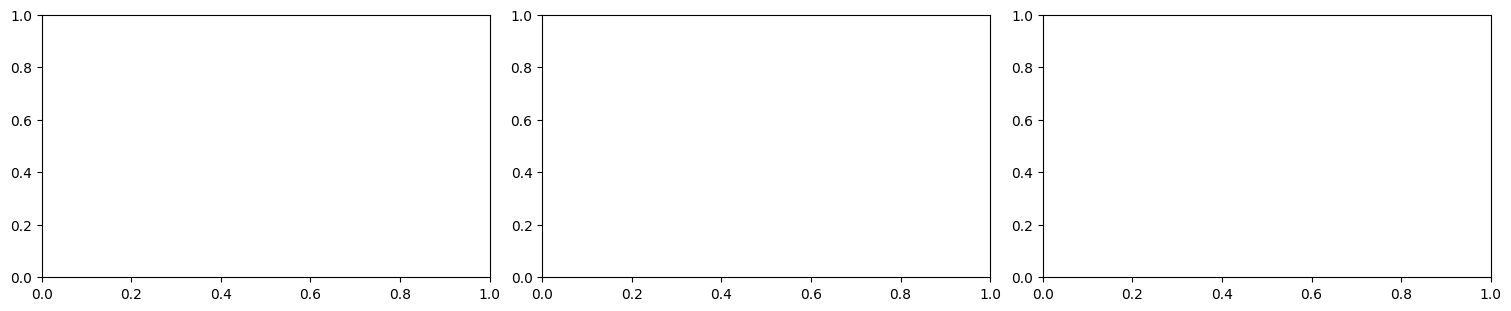

In [73]:
# Visualization

## x,y,z plotting
fig, axs = plt.subplots(1,3, figsize=(15,3), constrained_layout=True)
axs[0].step(time, x_bag[0, :], '#1f77b4', label=r'$x_x$')
#axs[0].step(time, x_ref[0,:], '#1f77b4', linestyle='--', label=r'$x_{xref}$')

axs[1].step(time, x_bag[1, :], '#ff7f0e', label="x_y")
#axs[1].step(time, x_ref[1,:], '#ff7f0e', linestyle='--', label="x_y ref")

axs[2].step(time, x_bag[2, :], '#2ca02c', label="x_z")
#axs[2].step(time, x_ref[2,:], '#2ca02c', linestyle='--', label="x_z ref")

#plt.step(x_bag[5, :], '#d62728', label="x_psi")
for ax, title in zip(axs, ['x (m)','y (m)','z (m)']):
    ax.set_xlabel("Time [s]")
    ax.set_title(f'{title}')
    ax.legend()
plt.show()
ZZ
## x,y,z plotting
fig, axs = plt.subplots(1,3, figsize=(15,3), constrained_layout=True)
axs[0].step(time, x_bag[3, :], '#1f77b4', label="x_phi")
#axs[0].step(time, x_ref[3,:], '#1f77b4', linestyle='--', label="x_phi ref")

axs[1].step(time, x_bag[4, :], '#ff7f0e', label="x_theta")
#axs[1].step(time, x_ref[4,:], '#ff7f0e', linestyle='--', label="x_theta ref")

axs[2].step(time, x_bag[5, :], '#2ca02c', label="x_psi")
#axs[2].step(time, x_ref[5,:], '#2ca02c', linestyle='--', label="x_psi ref")

#plt.step(x_bag[5, :], '#d62728', label="x_psi")
for ax, title in zip(axs, [r'roll $\phi$ (rad)',r'pitch $\theta$ (rad)',r'yaw $\psi$ (rad)']):
    ax.set_xlabel("Time [s]")
    ax.set_title(title)
    ax.legend()
plt.show()

'''
plt.figure(figsize=(15,3))
plt.step(time, u_bag[0, :], '#1f77b4', label="F")
plt.step(time, u_bag[1, :], '#ff7f0e', label="Tx")
plt.step(time,u_bag[2, :], '#2ca02c', label="Ty")
plt.step(time, u_bag[3, :], '#d62728', label="Tz")
plt.xlabel("Time [s]")
plt.title("Constrained MPC Control Inputs")
plt.legend()
plt.show()
'''
print()